In [166]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib

from jax.config import config
config.update("jax_enable_x64", True)

## import modules
import preconditioner as precond
import conjugate_gradient as cg
import pivoted_cholesky as pc
import pivoted_cholesky_ref as pc_ref # to use this script we need "torch", please comment out if not needed.
import calc_logdet
import calc_trace
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(pc_ref)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
reload()

import gpytorch
import torch
import linear_operator
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    DenseLinearOperator,
)

In [138]:
from stopro.data_generator.sinusoidal import Sinusoidal
from stopro.data_preparer.data_preparer import DataPreparer

In [139]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [140]:
project_name = 'test'
simulation_name = 'test'

### generate and save data

In [5]:
data_preparer = DataPreparer(
    project_name, simulation_name, class_data_generator=Sinusoidal
)
data_preparer.load_params(
    system_name="sinusoidal_new", use_existing_params=False
)
data_preparer.params_main["model"]["init_kernel_hyperparameter"] = {
    "uxux": [0.0, 1., 1.],
    "uyuy": [0.0, 1., 1.],
    "pp": [0.0, 1., 1.],
    # "uxuy": [0.0, 0.0, 0.0]
    # "noise": float(np.log(1.0e-06)),
}
data_preparer.params_kernel_arg = ["uxux", "uyuy", "pp"]
data_preparer.create_directory()

data_preparer.make_data()
data_preparer.save_params_prepare()
data_preparer.save_params_main()
data_preparer.save_lbls()

In [6]:
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
from stopro.GP.kernels import define_kernel
# from stopro.solver.optimizers import optimize_by_adam
from stopro.data_handler.data_handle_module import *

In [7]:
importlib.reload(gp_sinusoidal_independent)

<module 'stopro.GP.gp_sinusoidal_independent' from '/home/ogawa_kenta/opt/stopro/GP/gp_sinusoidal_independent.py'>

In [8]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [16]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])

args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]

In [10]:
init

DeviceArray([0., 1., 1., 0., 1., 1., 0., 1., 1.], dtype=float64)

In [11]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_sinusoidal_independent.GPSinusoidalWithoutPIndependent(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
)
gp_model.set_constants(*args_predict)
# loglikelihood, predictor = (
#     gp_model.trainingFunction_all,
#     gp_model.predictingFunction_all,
# )
# func = jit(logposterior(loglikelihood, params_optimization))
# dfunc = jit(grad(func, 0))
# hess = hessian(func)

## check $K^{-1}y$

### $\eta=0, l=0$

In [20]:
scale = 0.
length = 0.
noise = 1e-06
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [106]:
K = gp_model.trainingK_all(init, r_train)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [107]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(1.14976524e+09, dtype=float64))

In [108]:
np.max(K)

DeviceArray(9.000001, dtype=float64)

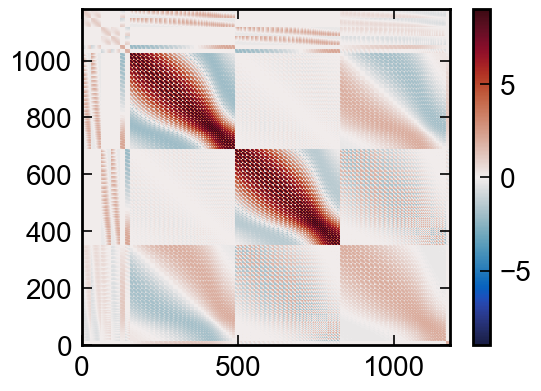

In [109]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [110]:
rank=5
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train.reshape(-1, 1)], axis=1)

In [111]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank)

In [112]:
Kinvy = cg.cg_bbmm(K, delta_y_train, precondition=precondition, print_process=False, tolerance=0.001)

In [113]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [114]:

rhs_torch = torch.from_numpy(np.array(rhs))

K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [115]:
linear_operator.settings.cg_tolerance._set_value(0.001)

In [116]:
Kinvy_torch = added_diag._solve(rhs_torch[:, -1:], preconditioner=None, num_tridiag=0, )

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.9042190600007949 which is larger than the tolerance of 0.001 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [117]:
yKy_linalg = delta_y_train@Kinvy_cholesky
yKy = delta_y_train@Kinvy
yKy_torch = delta_y_train@Kinvy_torch.numpy()

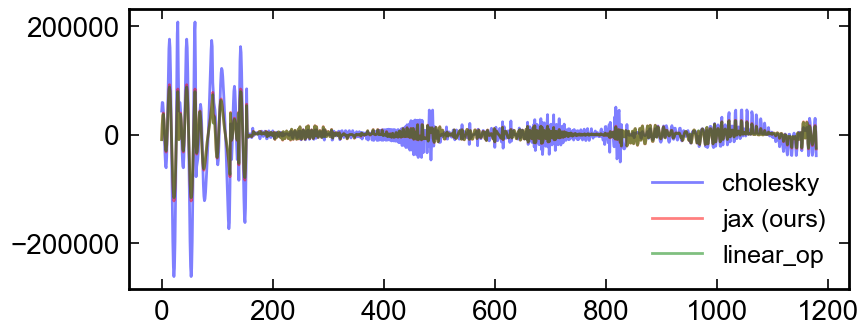

In [118]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy, color='r', alpha=alpha, label='jax (ours)')
ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

In [119]:
(yKy_linalg-yKy)/yKy_linalg, (yKy_linalg-yKy_torch)/yKy_linalg

(DeviceArray(0.42515762, dtype=float64),
 DeviceArray([0.44812688], dtype=float64))

In [120]:
sec_start = gp_model.sec_tr[4]
sec_last = gp_model.sec_tr[5]

In [121]:
K_part = K[sec_start:sec_last, sec_start:sec_last]
delta_y_part = delta_y_train[sec_start:sec_last]

In [176]:
is_positive_definite(K_part), jnp.linalg.cond(K)

NameError: name 'K_part' is not defined

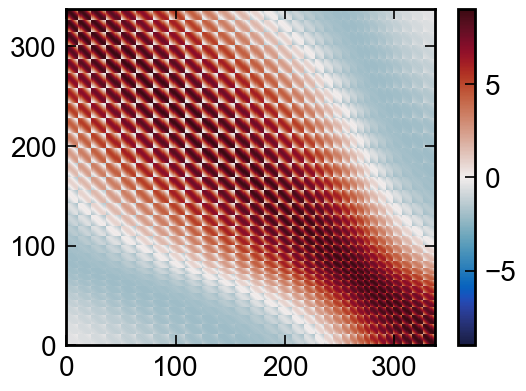

In [123]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K_part), vmin=-np.max(K_part), vmax=np.max(K_part), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [394]:
Kinvy = cg.cg_bbmm(K_part, delta_y_part, precondition=precondition, print_process=True, tolerance=1)

j=0 r1norm: 0.37985900652950294
j=1 r1norm: 0.24069229343595452
j=2 r1norm: 0.31675898175997597
j=3 r1norm: 0.11049968999864763
j=4 r1norm: 0.098076052470973
j=5 r1norm: 0.03745686630795005
j=6 r1norm: 0.014942039237406567
j=7 r1norm: 0.04154508114683784
j=8 r1norm: 0.022147083198149935
j=9 r1norm: 0.31448147983530056
j=10 r1norm: 0.011004243287288423
converged


In [395]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K_part)
v = jnp.linalg.solve(L, delta_y_part)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [396]:
Kinv_linalg = jnp.linalg.inv(K_part)
Kinvy_linalg = jnp.einsum("ij,j->i", Kinv_linalg, delta_y_part)

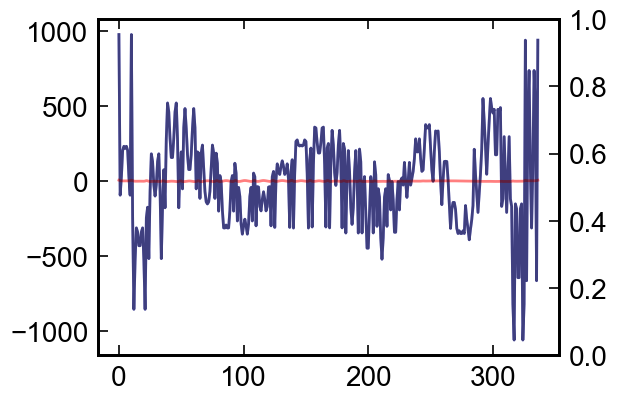

In [397]:
alpha = 0.5
fig, ax = plt.subplots()
ax.plot(Kinvy_cholesky, color='b', alpha=alpha)
ax.plot(Kinvy, color='r', alpha=alpha)
ax.plot(Kinvy_linalg, color='black', alpha=alpha)
# ax.set_ylim(-100, 100)
ax2 = ax.twinx()
# ax2.plot(delta_y_train, color='black', alpha=0.5)

In [398]:
yKy_linalg = delta_y_part@Kinvy_cholesky
yKy = delta_y_part@Kinvy
(yKy_linalg-yKy)/yKy_linalg

DeviceArray(0.49394527, dtype=float64)

### $\eta=0, l=-1$

In [18]:
scale = 0.
length = -1.
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [19]:
K = gp_model.trainingK_all(init, r_train)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [20]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(1.15342266e+10, dtype=float64))

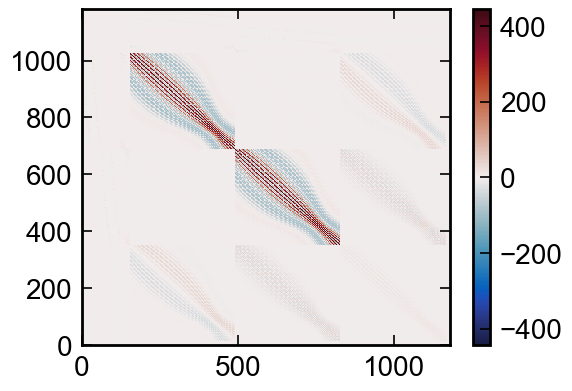

In [520]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [521]:
rank=5
noise = 1e-06
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train.reshape(-1, 1)], axis=1)

In [522]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank)

In [523]:
Kinvy = cg.cg_bbmm(K, delta_y_train, precondition=precondition, print_process=False, tolerance=0.001)

In [524]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [525]:

rhs_torch = torch.from_numpy(np.array(rhs))

K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [526]:
linear_operator.settings.cg_tolerance._set_value(0.001)

In [527]:
Kinvy_torch = added_diag._solve(rhs_torch[:, -1:], preconditioner=None, num_tridiag=0, )

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.2378029633716637 which is larger than the tolerance of 0.001 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [528]:
yKy_linalg = delta_y_train@Kinvy_cholesky
yKy = delta_y_train@Kinvy
yKy_torch = delta_y_train@Kinvy_torch.numpy()

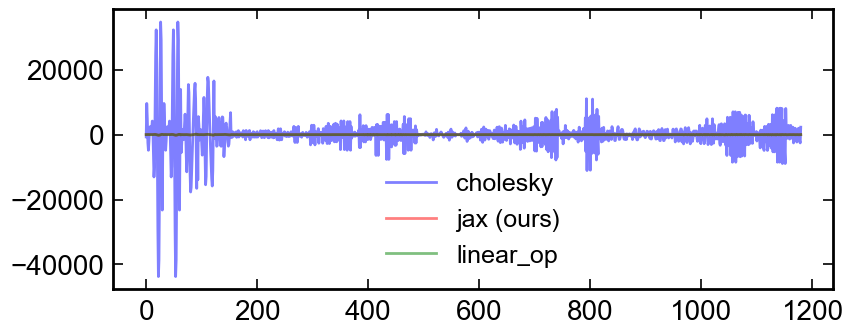

In [529]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy, color='r', alpha=alpha, label='jax (ours)')
ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

In [481]:
(yKy_linalg-yKy)/yKy_linalg, (yKy_linalg-yKy_torch)/yKy_linalg

(DeviceArray(0.42515762, dtype=float64),
 DeviceArray([0.57672884], dtype=float64))

### $\eta=0, l=0.5$

In [21]:
scale = 0.
length = 1.
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [22]:
K = gp_model.trainingK_all(init, r_train)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [23]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(1.06129738e+08, dtype=float64))

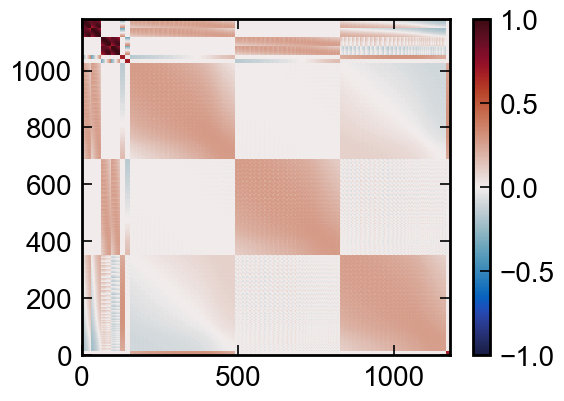

In [504]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [505]:
rank=5
noise = 1e-06
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train.reshape(-1, 1)], axis=1)

In [506]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank)

In [516]:
Kinvy = cg.cg_bbmm(K, delta_y_train, precondition=precondition, print_process=False, tolerance=0.001)

In [508]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [509]:

rhs_torch = torch.from_numpy(np.array(rhs))

K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [510]:
linear_operator.settings.cg_tolerance._set_value(0.001)

In [511]:
Kinvy_torch = added_diag._solve(rhs_torch[:, -1:], preconditioner=None, num_tridiag=0, )

In [512]:
yKy_linalg = delta_y_train@Kinvy_cholesky
yKy = delta_y_train@Kinvy
yKy_torch = delta_y_train@Kinvy_torch.numpy()

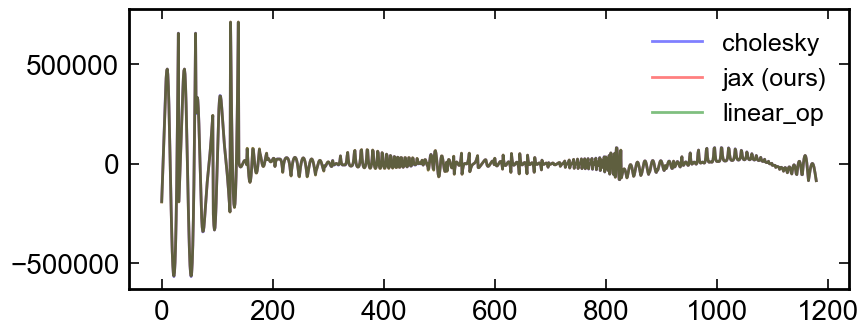

In [513]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy, color='r', alpha=alpha, label='jax (ours)')
ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

In [514]:
(yKy_linalg-yKy)/yKy_linalg, (yKy_linalg-yKy_torch)/yKy_linalg

(DeviceArray(0.00016498, dtype=float64),
 DeviceArray([0.00016282], dtype=float64))

### scale coordinate x10 $\eta=0, l=2.3$

In [167]:
scale = 0.
length = 2.3
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [142]:
### scale data ###
scale = 10
r_train_scaled = [_r * scale for _r in r_train]
r_test_scaled = [_r * scale for _r in r_test]
# delta_y_train_scaled = delta_y_train.copy()
# delta_y_train_scaled[4] = delta_y_train_scaled[4] / scale**2
delta_y_train_scaled = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train_scaled = jnp.append(
        delta_y_train_scaled, f_train[i] / scale**2 - μ_train[i]
    )
print(delta_y_train_scaled)

[0. 0. 0. ... 0. 0. 0.]


In [143]:
K = gp_model.trainingK_all(init, r_train_scaled)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [144]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(34566274.31316964, dtype=float64))

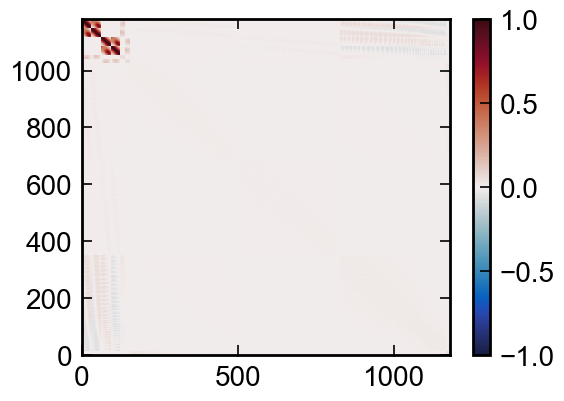

In [145]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [146]:
rank=5
noise = 1e-06
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train_scaled), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train_scaled.reshape(-1, 1)], axis=1)

In [147]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank)

In [172]:
Kinvy = cg.cg_bbmm(K, delta_y_train_scaled, precondition=precondition, print_process=False, tolerance=0.001)

In [173]:
Kinvy_rhs = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=False, tolerance=0.001, n_tridiag=0)

### j=785に収束した

In [157]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train_scaled)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [158]:
rhs_torch = torch.from_numpy(np.array(rhs))

K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [159]:
linear_operator.settings.cg_tolerance._set_value(0.001)

In [160]:
Kinvy_torch = added_diag._solve(rhs_torch[:, -1:], preconditioner=None, num_tridiag=0, )

In [161]:
yKy_linalg = delta_y_train@Kinvy_cholesky
yKy = delta_y_train@Kinvy
yKy_torch = delta_y_train@Kinvy_torch.numpy()

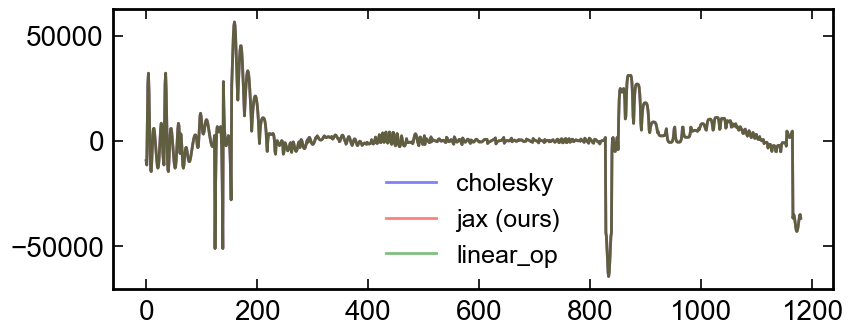

In [175]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy, color='r', alpha=alpha, label='jax (ours)')
ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

In [155]:
(yKy_linalg-yKy)/yKy_linalg, (yKy_linalg-yKy_torch)/yKy_linalg

(DeviceArray(8.42929623e-05, dtype=float64),
 DeviceArray([7.55169971e-06], dtype=float64))

### scale coordinate x30 $\eta=0, l=2.3$

In [104]:
scale = 0.
length = 3.3
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [120]:
init = jnp.array([ 0.71538226,  2.19819793,  2.24535661,  0.43420748,  2.23344691,  2.41665109,
 -1.86043841,  2.38322337,  3.28660882])

In [121]:
### scale data ###
scale = 30
r_train_scaled = [_r * scale for _r in r_train]
r_test_scaled = [_r * scale for _r in r_test]
# delta_y_train_scaled = delta_y_train.copy()
# delta_y_train_scaled[4] = delta_y_train_scaled[4] / scale**2
delta_y_train_scaled = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train_scaled = jnp.append(
        delta_y_train_scaled, f_train[i] / scale**2 - μ_train[i]
    )
print(delta_y_train_scaled)

[0. 0. 0. ... 0. 0. 0.]


In [122]:
K = gp_model.trainingK_all(init, r_train_scaled)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [123]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(17918296.96505406, dtype=float64))

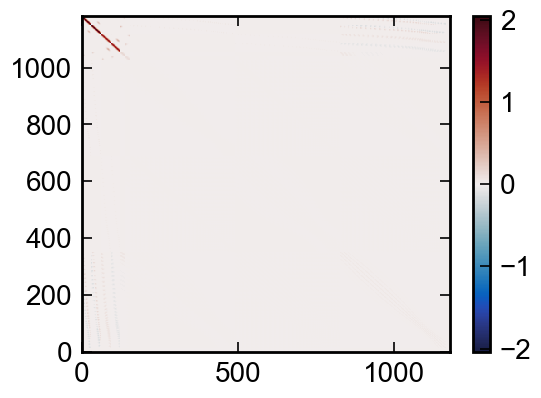

In [124]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [125]:
rank=5
noise = 1e-06
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train_scaled), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train_scaled.reshape(-1, 1)], axis=1)

In [126]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank)

In [135]:
Kinvy = cg.cg_bbmm(K, delta_y_train_scaled, precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=3000)

### j=950に収束した

In [128]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train_scaled)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [129]:
rhs_torch = torch.from_numpy(np.array(rhs))

K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train_scaled), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [130]:
linear_operator.settings.cg_tolerance._set_value(0.01)

In [131]:
Kinvy_torch = added_diag._solve(rhs_torch[:, -1:], preconditioner=None, num_tridiag=0, )

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.1703544210313526 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [132]:
yKy_linalg = delta_y_train@Kinvy_cholesky
yKy = delta_y_train@Kinvy
yKy_torch = delta_y_train@Kinvy_torch.numpy()

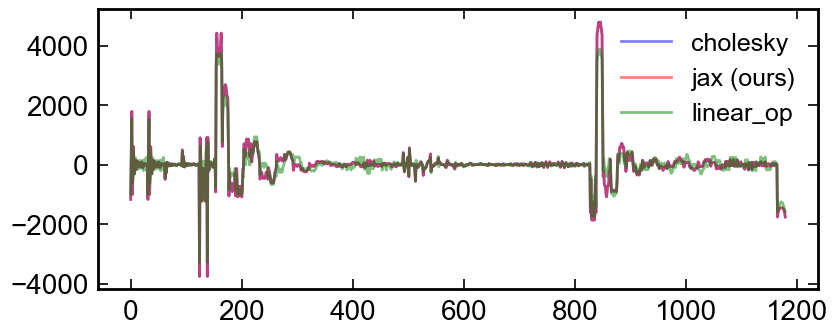

In [136]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy, color='r', alpha=alpha, label='jax (ours)')
ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

In [134]:
(yKy_linalg-yKy)/yKy_linalg, (yKy_linalg-yKy_torch)/yKy_linalg

(DeviceArray(0.08629843, dtype=float64),
 DeviceArray([0.08841535], dtype=float64))

## NO USE: make covariance matrix well conditioned: make diagonal of $K_{ff}=1$

In [12]:
import stopro.GP.gp_sinusoidal_Re as gp_sinusoidal_Re
import stopro.GP.gp_2D_stokes_Re as gp_2D_stokes_Re
importlib.reload(gp_sinusoidal_Re)
importlib.reload(gp_2D_stokes_Re)

<module 'stopro.GP.gp_2D_stokes_Re' from '/home/ogawa_kenta/opt/stopro/GP/gp_2D_stokes_Re.py'>

In [13]:
def calc_good_Re_given_lengthscale(l_ui_x, l_ui_y, l_p_i, mu_ui=1., mu_p=1.):
    Re_square = mu_ui*(3/l_ui_x**4+2/(l_ui_x**2*l_ui_y**2)+3/l_ui_y**4)/(1-mu_p*1/l_p_i**2)
    return np.sqrt(Re_square)

In [14]:
l = 1.1
mu = 1
noise = 1e-06
l_ui_x = l
l_ui_y = l
l_p_i = l
Re = calc_good_Re_given_lengthscale(l_ui_x, l_ui_y, l_p_i, mu_ui=mu, mu_p=mu)
Re

5.611030907712431

In [146]:
scale = np.log(mu)
length = np.log(1)
# length = np.log(2)
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [147]:
init

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [157]:
scale = 20

In [158]:
r_train_scaled = []
for _r in r_train:
    r_train_scaled.append(_r*scale)

In [159]:
gp_model = gp_sinusoidal_Re.GPSinusoidalRe(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5*scale, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
    Re=1.
)
gp_model.set_constants(*args_predict)

In [160]:
K = gp_model.trainingK_all(init, r_train_scaled)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [161]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(154.54383278, dtype=float64))

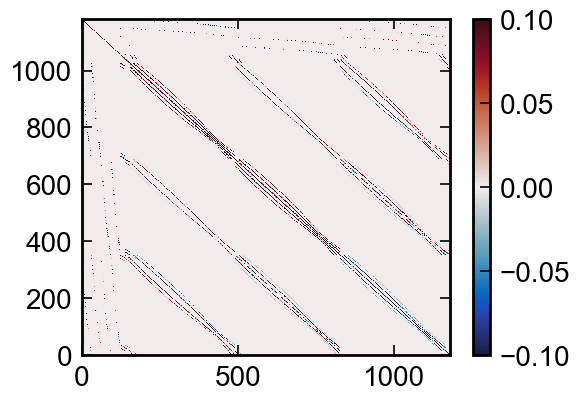

In [175]:
fig, ax = plt.subplots()
# mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(np.abs(K)), vmax=np.max(np.abs(K)), cmap=cmo.cm.balance)
mappable = ax.pcolormesh(np.flipud(K), vmin=-0.1, vmax=0.1, cmap=cmo.cm.balance)
fig.colorbar(mappable)

(0.0, 10.000001)

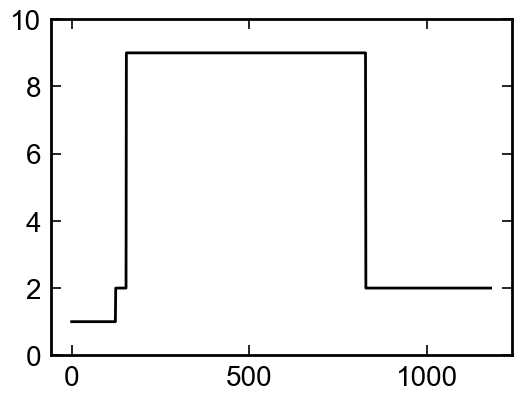

In [163]:
fig, ax = plt.subplots()
ax.plot(jnp.diag(K))
ax.set_ylim(0, jnp.max(K)+1)

In [164]:
rank=5
noise = 1e-06
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train.reshape(-1, 1)], axis=1)

In [165]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank)

In [166]:
Kinvy = cg.cg_bbmm(K, delta_y_train, precondition=precondition, print_process=True,  tolerance=0.001)

j=0 r1norm: 0.4111992644133728
j=1 r1norm: 0.1847676488326368
j=2 r1norm: 0.0917394224223422
j=3 r1norm: 0.04334027232380525
j=4 r1norm: 0.025003673328115147
j=5 r1norm: 0.0191305003456609
j=6 r1norm: 0.01875155288257719
j=7 r1norm: 0.01665743567894251
j=8 r1norm: 0.01343790547366942
j=9 r1norm: 0.011862459418238814
j=10 r1norm: 0.01038043000639555
j=11 r1norm: 0.008904920521395153
j=12 r1norm: 0.007100910681459487
j=13 r1norm: 0.005866784783047841
j=14 r1norm: 0.006166053524653731
j=15 r1norm: 0.005729076036022371
j=16 r1norm: 0.004497353744358641
j=17 r1norm: 0.0033337824021316452
j=18 r1norm: 0.0027071660457376103
j=19 r1norm: 0.0024013113277799847
j=20 r1norm: 0.002196381370086375
j=21 r1norm: 0.0018469413481882516
j=22 r1norm: 0.0013773009156328247
j=23 r1norm: 0.0009705582763472249
converged


In [167]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [168]:
rhs_torch = torch.from_numpy(np.array(rhs))

K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [169]:
linear_operator.settings.cg_tolerance._set_value(0.001)

In [170]:
Kinvy_torch = added_diag._solve(rhs_torch[:, -1:], preconditioner=None, num_tridiag=0, )

In [171]:
yKy_linalg = delta_y_train@Kinvy_cholesky
yKy = delta_y_train@Kinvy
yKy_torch = delta_y_train@Kinvy_torch.numpy()

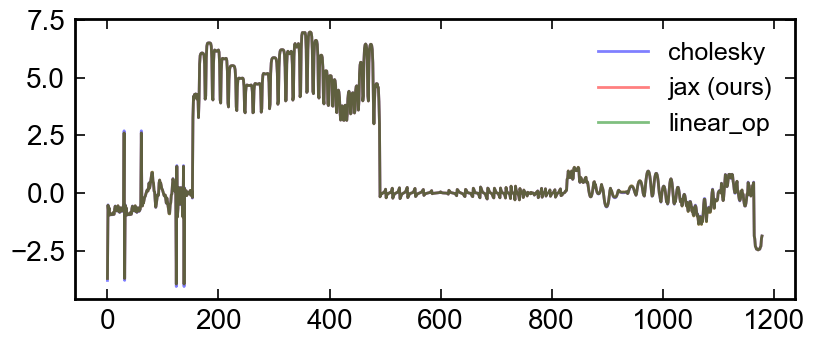

In [172]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy, color='r', alpha=alpha, label='jax (ours)')
ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

In [173]:
(yKy_linalg-yKy)/yKy_linalg, (yKy_linalg-yKy_torch)/yKy_linalg

(DeviceArray(1.92718317e-06, dtype=float64),
 DeviceArray([1.92718317e-06], dtype=float64))

In [47]:
np.max(K)

DeviceArray(1.08329705, dtype=float64)

In [49]:
index_max = np.argmax(K)

In [55]:
i_max = index_max // len(K)
j_max = index_max % len(K)

In [56]:
i_max, j_max

(DeviceArray(124, dtype=int64), DeviceArray(1034, dtype=int64))

In [58]:
gp_model.sec_tr

array([   0,   62,  124,  139,  154,  491,  828, 1165, 1180])